In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision import *
from utility import *

In [3]:
path = Path('/home/jupyter/.fastai/data/humpback')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/humpback/validation_random.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train'),
 PosixPath('/home/jupyter/.fastai/data/humpback/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/models')]

In [4]:
df_raw = preprocess(path/'train.csv')
df_new_whale = df_raw[df_raw['Id']=='new_whale']
df_train_valid = df_raw[df_raw['Id']!='new_whale']
df_oversampled_train = pd.read_csv('oversampled_train.csv')
df_raw.shape,df_new_whale.shape,df_train_valid.shape,df_oversampled_train.shape

((25361, 3), (9664, 3), (15697, 3), (75766, 4))

In [5]:
sz = 224
bs = 64

In [6]:
data = (ImageList.from_df(df_train_valid,path=path,cols='Image',folder='train')
       .split_from_df(col='is_valid')
       .label_from_df(cols='Id')
       .transform(tfms=get_transforms(),size=sz,resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [7]:
learn = create_cnn(data,models.resnet50,lin_ftrs=[1024],metrics=[accuracy,mapk])

In [15]:
learn.lr_find(end_lr=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


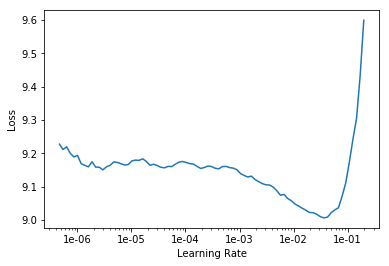

In [16]:
learn.recorder.plot()

In [17]:
lr=1e-2/2

In [18]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,mapk,time
1,8.074516,6.883336,0.085912,0.117895,02:28
2,7.116859,5.340398,0.194218,0.248059,02:22
3,5.568814,4.334393,0.289902,0.356033,02:25
4,3.758991,3.791487,0.374593,0.433652,02:27
5,2.339536,3.698611,0.385586,0.447774,02:26


In [19]:
learn.save('resnet-50-224-stage-1')

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


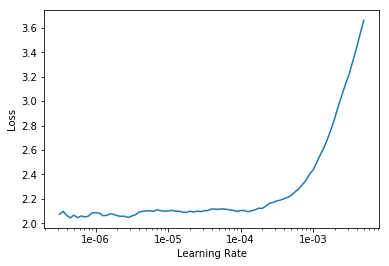

In [29]:
learn.lr_find(end_lr=1e-2)
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(6,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,mapk,time
1,2.509123,3.695133,0.393730,0.454153,03:01
2,3.000761,3.456923,0.419788,0.482471,03:02
3,2.507912,3.254104,0.448697,0.511740,03:02
4,1.698488,2.989240,0.498778,0.559155,03:02
5,1.090023,2.859516,0.512215,0.576554,03:02
6,0.814705,2.828992,0.520358,0.582526,03:02


In [31]:
learn.save('resnet-50-224-stage-2')

In [9]:
df_valid = df_train_valid[df_train_valid['is_valid']==True]
df_valid.shape

(2456, 3)

In [24]:
df_oversample_total = pd.concat([df_oversampled_train,df_valid])
df_oversampled_train.shape,df_oversample_total.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


((75766, 4), (78222, 4))

In [40]:
df_oversample_total.to_csv('oversampled_train_vaild.csv')

In [25]:
sz = 224 * 2
bs = 64 // 4

In [26]:
data = (ImageList.from_df(df_oversample_total,path=path,cols='Image',folder='train')
       .split_from_df(col='is_valid')
       .label_from_df(cols='Id')
       .add_test_folder()
       .transform(tfms=get_transforms(),size=sz,resize_method=ResizeMethod.SQUISH)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [28]:
learn.data = data

In [29]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


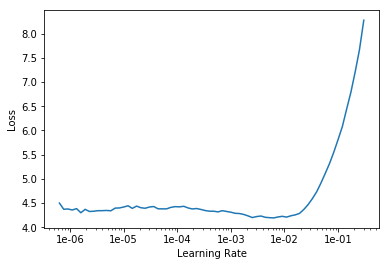

In [15]:
learn.lr_find()
learn.recorder.plot()

In [30]:
lr = 1e-3
learn.fit_one_cycle(2,slice(lr))

epoch,train_loss,valid_loss,accuracy,mapk,time
1,3.329314,5.054866,0.322883,0.381515,45:51
2,3.038692,5.189719,0.420603,0.484059,45:54


In [31]:
learn.save('resnet-50-448-stage-1')